In [1]:
# Functions
# %run data_prep_fns/general_scale.py

# Multiple Outputs per cell
%config interactive_shell.ast_node_interactivity='all'

# Read in test datasets
import pickle
import os
os.chdir('C:/Users/WulfN/Python Projects/time_series_model_comparison')

# Energy data
with open('datasets/energy_dt.pickle', 'rb') as file:
    energy_dt = pickle.load(file)  

# GLobal Population data
with open('datasets/glob_pop.pickle', 'rb') as file_2:
    glob_pop_dt = pickle.load(file_2)

### Testing / Validation Split

In [2]:

# from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split datasets into testing and validation

# Energy data
x_energy = energy_dt.drop(columns = ['total_Wh', 'rv1', 'rv2'])
x_energy_sc = MinMaxScaler().fit_transform(x_energy)
y_energy = energy_dt['total_Wh']
# y_energy_sc = MinMaxScaler().transform(y_energy) # transform so as not to introduce bias from training set from fit() function the testing set
### Test how scaling or NOT scaling y affects the model ###

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_energy_sc, y_energy, test_size = .2, shuffle = False)

# Global Population data
x_glob_pop = glob_pop_dt.drop(columns = ['Population'])
x_glob_pop_sc = MinMaxScaler().fit_transform(x_glob_pop)
y_glob_pop = glob_pop_dt['Population']
# y_glob_pop_sc = MinMaxScaler().transform(y_glob_pop)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_glob_pop_sc, y_glob_pop, test_size = .2, shuffle = False)


In [32]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# Test how different window sizes affect model prediction accuracy
window_size = 144 # 6, 24, 72, 144, length of validation set
ts_train_windows = timeseries_dataset_from_array(data=x_train_1, targets=y_train_1, sequence_length=window_size) 
ts_test_windows = timeseries_dataset_from_array(data=x_test_1, targets=y_test_1, sequence_length=window_size)

In [62]:
### Building familiarity with keras and LSTM params
import tensorflow as tf
import keras

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=3, 
                                            min_delta=1,
                                            restore_best_weights=True,
                                            start_from_epoch=5) 

lstm = tf.keras.Sequential() 
lstm.add(tf.keras.layers.LSTM(
    units=128, 
    activation='relu', 
    input_shape=(window_size, x_train_1.shape[1]),
    return_sequences=True))
lstm.add(tf.keras.layers.Dropout(.2)) 
lstm.add(tf.keras.layers.LSTM(
    units=128, 
    activation='relu')) 
lstm.add(tf.keras.layers.Dropout(.2)) 
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(loss='mse', 
             optimizer=tf.keras.optimizers.Adam(learning_rate=.001)
             ) 

lstm.fit(x=ts_train_windows, 
         shuffle=False,
         epochs=100, # max epochs
         callbacks = [callback])

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 21797.7051
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 15780.3633
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 16335.5693
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 14410.4580
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 15610.1729
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 14468.5947
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 14223.8301
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 13924.8125
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 13923.8535
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 13772.7012
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 13820.9502
Epoch 12/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 13573.4131
Epoch 13/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 13562.1562
Epoch 14/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 5

In [38]:
batch_size = 16 # 32, 64

### First try batch_input size for single layer
lstm = tf.keras.Sequential() 
lstm.add(tf.keras.layers.LSTM(
        units=128, # range, min = 128, max = 256 instead
        activation='relu', 
        # input_shape=(window_size, x_train_1.shape[1]),
        batch_shape=(batch_size, window_size, x_train_1.shape[1]),
        stateful=True)) # input_shape and batch_shape?
lstm.add(tf.keras.layers.Dropout(.2)) 
lstm.add(tf.keras.layers.Dense(1))

# do I reset states here, after layer, or after epoch, it has been compiled?
# consider testing how the model performs after reseting states in different places

lstm.compile(loss='mse', optimizer='adam', learning_rate=0.001)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=3, 
                                            min_delta=1,
                                            restore_best_weights=True,
                                            start_from_epoch=5) 


# Test if reset_states is helpful for the model
# if reset_states, each epoch has non-trained waits (like a different model per epoch)

lstm.fit(x=ts_train_windows, 
         shuffle=False,
         epochs=100, # Consider raising this value (100)
         callbacks=[callback])

### Then try batch_input size for 2 layer (Code initially commented)
# lstm = tf.keras.Sequential() 
# lstm.add(tf.keras.layers.LSTM(
#         units=128), # range, min = 128, max = 256 instead
#         activation='relu', 
#         # input_shape=(window_size, x_train_1.shape[1]),
#         batch_shape=(batch_size, window_size, x_train_1.shape[1]),
#         stateful=True) # input_shape and batch_shape?
# lstm.add(tf.keras.layers.Dropout(.2)) 
# lstm.add(ts.keras.layers.LSTM(
#     units=128,
#     activation='relu',
#     batch_shape=(batch_size, window_size, x_train_1.shape[1]), # consider removing this
#     stateful=True # consider removing this
# ))
# lstm.add(tf.keras.layers.Dropout(.2)) 
# lstm.add(tf.keras.layers.Dense(1))

# lstm.compile(loss='mse', optimizer='adam', learning_rate=0.001)

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
#                                             patience=3, 
#                                             min_delta=1,
#                                             restore_best_weights=True,
#                                             start_from_epoch=5) 

# lstm.fit(x=ts_train_windows, 
#          shuffle=False,
#          epochs=100, # Consider raising this value (100)
#          callbacks=[callback])

ValueError: Unrecognized keyword arguments passed to LSTM: {'batch_input_shape': (16, 144, 24)}

In [35]:
import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# https://keras.io/guides/keras_tuner/getting_started/

def lstm_model_build(hp):
    
    model_type = hp.Choice("model_type", ["base_dropout", "twostack_dropout"])
    # change project name as needed
    batch_size = hp.Choice("batch_size", [16, 32, 64])

    # Perhaps include data window size variations too

    # if model_type == 'base':
    #     lstm = tf.keras.Sequential() 
    #     lstm.add(tf.keras.layers.LSTM(
    #         hp.Choice('units', [128, 182, 256]), # range, min = 128, max = 256 instead
    #         activation='relu',
    #         input_shape=(window_size, x_train_1.shape[1]))) 
    #     lstm.add(tf.keras.layers.Dense(1))

    if model_type == 'base_dropout':
        lstm = tf.keras.Sequential() 
        lstm.add(tf.keras.layers.LSTM(
            hp.Choice('units_1', [128, 182, 256]), # range, min = 128, max = 256 instead
            activation='relu', 
            # input_shape=(window_size, x_train_1.shape[1]),
            batch_shape=(batch_size, window_size, x_train_1.shape[1]),
            stateful=True)) # input_shape and batch_shape?
        lstm.add(tf.keras.layers.Dropout(.2)) 
        lstm.add(tf.keras.layers.Dense(1))

    elif model_type == 'twostack_dropout':
        lstm = tf.keras.Sequential() 
        lstm.add(tf.keras.layers.LSTM(
            hp.Choice('units_1', [128,256]), 
            activation='relu', 
            input_shape=(window_size, x_train_1.shape[1]), # assuming stateful is needed at each layer of the dataset
            return_sequences=True,
            batch_shape=(batch_size, window_size, x_train_1.shape[1]),
            stateful=True
            ))
        lstm.add(tf.keras.layers.Dropout(.2)) 
        lstm.add(tf.keras.layers.LSTM(
            hp.Choice('units_2', [56, 128]), # is batch_input_size and stateful needed here?
            activation='relu')) 
        lstm.add(tf.keras.layers.Dropout(.2)) 
        lstm.add(tf.keras.layers.Dense(1))

    learning_rate = hp.Choice('learning_rate', [.001, .01])

    lstm.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    # reset_states()      
    return lstm

tuner = kt.Hyperband(
    hypermodel=lstm_model_build,
    objective=kt.Objective('loss', direction = 'min'),
    batch_size=16, # what are the optimal batch sizes? 
    # allow_new_entries
    # logger
    executions_per_trial=5,
    seed=89,
    directory='keras_tuner_dir', 
    project_name='lstm', # adjust as needed
    overwrite=True) 

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=3, 
                                            min_delta=1,
                                            restore_best_weights=True,
                                            start_from_epoch=5) 



# Perform hyperparameter search
tuner.search(
    x=ts_train_windows, 
    shuffle=False,
    epochs=100, # Consider raising this value (100)
    callbacks=[callback]
)
# Consider batch size

Trial 2 Complete [00h 10m 57s]
loss: nan

Best loss So Far: nan
Total elapsed time: 00h 17m 51s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
twostack_dropout  |base_dropout      |model_type
182               |128               |units_1
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 109s 855ms/step - loss: nan
Epoch 2/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 106s 860ms/step - loss: nan
Epoch 1/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 106s 828ms/step - loss: nan
Epoch 2/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 99s 803ms/step - loss: nan
Epoch 1/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 116s 907ms/step - loss: nan
Epoch 2/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 98s 796ms/step - loss: nan
Epoch 1/2
123/123 ━━━━━━━━━━━━━━━━━━━━ 117s 917ms/step - loss: na

RuntimeError: Number of consecutive failures exceeded the limit of 3.


In [5]:
# Rank of tested models with lowest loss listed first
tuner.results_summary()

# May be time to implement a google cloud account for more computational power

Results summary
Results in keras_tuner_144_window\lstm
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0000 summary
Hyperparameters:
model_type: base_dropout
units_1: 128
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 12164.928125

Trial 0035 summary
Hyperparameters:
model_type: base_dropout
units_1: 128
learning_rate: 0.001
units_2: 182
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 12170.6759765625

Trial 0038 summary
Hyperparameters:
model_type: base_dropout
units_1: 128
learning_rate: 0.001
units_2: 56
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 12191.525

Trial 0027 summary
Hyperparameters:
model_type: base_dropout
units_1: 128
learning_rate: 0.001
units_2: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 12252.963671875

Trial 0036 summary
Hyperparameters:
model_type: base_dropout
units_1: 128
learning_rate: 0.

### Best Params of Optimal Model

In [7]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0].values

# Params of optimal model

In [12]:
best_params

{'model_type': 'base_dropout',
 'units_1': 128,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

### Save Best Model

In [31]:
%%capture
# Best model
best_model_8_23a = tuner.get_best_models()[0]

# Save model from this run 
best_model_8_23a.save("./best_models/lstm_best_model_8_23a.keras") # lstm, save format? 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


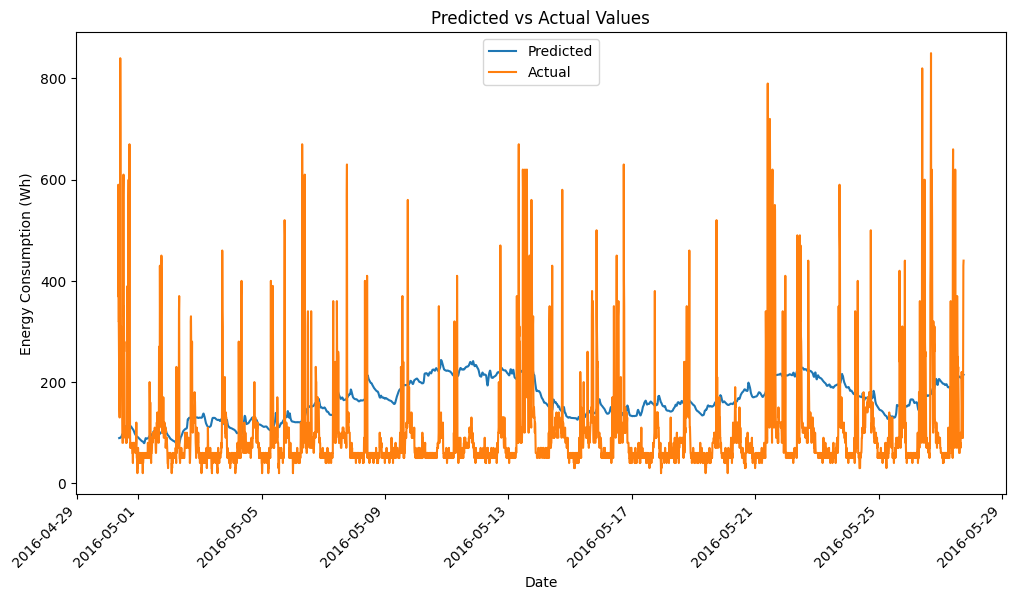

In [30]:
### Convert output to correct format for graphing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# remove first 50 min of actuals since x values are used for prediction
y_actuals = y_test_1[(window_size-1):]
#len(y_test_1.index)

y_hat = pd.DataFrame(best_model_8_23a.predict(ts_test_windows), index = y_actuals.index)
# best_model.evaluate() exists also, what is this? 
y_hat['predicted_Wh'] = y_hat[0]
y_hat = y_hat.drop(columns = 0)

# Set the figure size
plt.figure(figsize=(12, 6))
sns.lineplot(data=y_hat['predicted_Wh'], label='Predicted')
sns.lineplot(data=y_test_1, label='Actual')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()
